In [2]:
#initial data exploration

import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import seaborn as sns
%matplotlib inline

records = pd.DataFrame.from_csv('records.csv')
over_50 = records.loc[records['over_50k'] == 1] #all rows where income > $50k
under_50 = records.loc[records['over_50k'] == 0] #all rows where income <= $50k

#some general information about the dataset
print(str(over_50.shape[0]) + ' individuals earning >$50k (' + str('%.2f'%(100*over_50.shape[0]/(over_50.shape[0]+under_50.shape[0]))) + '%)')
print(str(under_50.shape[0]) + ' individuals earning <=$50k (' + str('%.2f'%(100*under_50.shape[0]/(over_50.shape[0]+under_50.shape[0]))) + '%)')
print('\nSummary of continuous variables:\n')
print(records.drop(['over_50k'], axis=1).describe()) #summary statistics for each continuous variable

C:\Users\Lucas McCabe\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  if __name__ == '__main__':


11687 individuals earning >$50k (23.93%)
37155 individuals earning <=$50k (76.07%)

Summary of continuous variables:

                age  education_num  capital_gain  capital_loss    hours_week
count  48842.000000   48842.000000  48842.000000  48842.000000  48842.000000
mean      38.643585      10.078089   1079.067626     87.502314     40.422382
std       13.710510       2.570973   7452.019058    403.004552     12.391444
min       17.000000       1.000000      0.000000      0.000000      1.000000
25%       28.000000       9.000000      0.000000      0.000000     40.000000
50%       37.000000      10.000000      0.000000      0.000000     40.000000
75%       48.000000      12.000000      0.000000      0.000000     45.000000
max       90.000000      16.000000  99999.000000   4356.000000     99.000000


It is worth noting that a model that simply guesses that everybody earns less than or equal to \$50,000 would achieve roughly 76% accuracy on this dataset.

The means, standard deviations, and quartiles of the capital gain and capital loss variables indicate to me that the variables are heavily skewed, but I will verify this below. At least half the individuals in the dataset work for 40-45 hours per week.

In [3]:
#obervations re: capital gain/loss
print('Skewness of continuous variables:\n')
print(records.skew())

print('\nNumber of instances of both non-zero capital gain and capital loss: ' + str(records.loc[(records['capital_gain'] >0) & (records['capital_loss'] >0)].shape[0]))

Skewness of continuous variables:

age               0.557580
education_num    -0.316525
capital_gain     11.894659
capital_loss      4.569809
hours_week        0.238750
over_50k          1.222216
dtype: float64

Number of instances of both non-zero capital gain and capital loss: 0


Capital gain and capital loss are heavily skewed variables, whereas the other continuous variables are not particularly skewed. They are also mutually-exclusive in that there are zero instances of both non-zero capital gain and capital loss. For this reason, I think it would be a good idea to consolidate the two variables into one variable representing the net capital gain/loss.

In [4]:
records['delta_capital'] = records['capital_gain'] - records['capital_loss'] #create net capital gain/loss variable
records.drop('capital_gain', axis=1, inplace=True) #we don't need this anymore
records.drop('capital_loss', axis=1, inplace=True) #we don't need this anymore

#now over_50k is no longer the rightmost column, so I'm going to swap it with the delta_capital column
cols = list(records)
cols[11], cols[12] = cols[12], cols[11]
records = records.loc[:, cols]

print('\nSkewness of continuous variables:\n')
print(records.skew())



Skewness of continuous variables:

age               0.557580
education_num    -0.316525
hours_week        0.238750
delta_capital    11.814939
over_50k          1.222216
dtype: float64


Predictably, the delta_capital variable is heavily skewed, just like its parent variables. I would like to use a logarithmic transformation so that particularly high or low values don't interfere with training model(s). I will also normalize the continuous variables by their z-scores.

In [5]:
records['delta_capital'] = records['delta_capital'].apply(lambda i: np.log(i+1)) #log normalization
cont_cols = ['age','education_num','hours_week','delta_capital'] #list of continuous variables
records[cont_cols] = (records[cont_cols] - records[cont_cols].mean())/records[cont_cols].std() #z-score normalize continuous variables
print(records.describe())

                age  education_num    hours_week  delta_capital      over_50k
count  4.884200e+04   4.884200e+04  4.884200e+04   4.656000e+04  48842.000000
mean   4.303075e-16  -7.796702e-17 -3.416410e-16  -5.233071e-16      0.239282
std    1.000000e+00   1.000000e+00  1.000000e+00   1.000000e+00      0.426649
min   -1.578613e+00  -3.530994e+00 -3.181420e+00  -3.057938e-01      0.000000
25%   -7.763085e-01  -4.193310e-01 -3.408661e-02  -3.057938e-01      0.000000
50%   -1.198778e-01  -3.037315e-02 -3.408661e-02  -3.057938e-01      0.000000
75%    6.824264e-01   7.475425e-01  3.694176e-01  -3.057938e-01      0.000000
max    3.745770e+00   2.303374e+00  4.727263e+00   4.300778e+00      1.000000


In [6]:
col_names = records.columns.tolist() #get all column names, convert index to list
for i in col_names:
    try:
        count = records.loc[records[i] == '?'].shape[0] #number of rows that have ? in column i
        print('Instances of ? in ' + i + ': '+ str(count))
    except: #general error handling
        print('Instances of ? in ' + i + ': 0')

Instances of ? in age: 0
Instances of ? in workclass_id: 2799
Instances of ? in education_level_id: 0
Instances of ? in education_num: 0
Instances of ? in marital_status_id: 0
Instances of ? in occupation_id: 2809
Instances of ? in relationship_id: 0
Instances of ? in race_id: 0
Instances of ? in sex_id: 0
Instances of ? in hours_week: 0
Instances of ? in country_id: 857
Instances of ? in delta_capital: 0
Instances of ? in over_50k: 0


C:\Users\Lucas McCabe\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\ops.py:816: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(x, name)(y)


I suspect that the vast majority of instances of ? in workclass_id and occupation_id occur in the same rows.

In [7]:
count_wo = records.loc[(records['workclass_id'] == '?') & (records['occupation_id'] == '?')].shape[0] #instances of ? in both workclass_id and occupation_id
count_wc = records.loc[(records['workclass_id'] == '?') & (records['country_id'] == '?')].shape[0] #instances of ? in both workclass_id and country_id
count_co = records.loc[(records['country_id'] == '?') & (records['occupation_id'] == '?')].shape[0] #instances of ? in both country_id and occupation_id
count_wco = records.loc[(records['workclass_id'] == '?') & (records['country_id'] == '?') & (records['occupation_id'] == '?')].shape[0] #instances of ? in workclass_id, country_id, and occupation_id
count_q = records.loc[(records['workclass_id'] == '?') | (records['country_id'] == '?') | (records['occupation_id'] == '?')].shape[0] #instances of ? in any of workclass_id, country_id, and occupation_id

print('Instances of both ? in both workclass_id and occupation_id: ' + str(count_wo))
print('Instances of both ? in both workclass_id and country_id: ' + str(count_wc))
print('Instances of both ? in both country_id and occupation_id: ' + str(count_co))
print('Instances of ? in workclass_id, country_id, and occupation_id: ' + str(count_wco))
print('Total instances of ?: ' + str(count_q) + ' (' + str('%.2f'%(100*count_q/(records.shape[0]))) + '%)')

Instances of both ? in both workclass_id and occupation_id: 2799
Instances of both ? in both workclass_id and country_id: 46
Instances of both ? in both country_id and occupation_id: 46
Instances of ? in workclass_id, country_id, and occupation_id: 46
Total instances of ?: 3620 (7.41%)


Every instance of ? in workclass_id coincides with an instance of ? in occupation_id. There are a few rare instances of ? occuring in workclass_id, country_id, and occupation_id. Since only 7.41% of the rows have missing data, I think it would be safe to just remove them.

In [8]:
records = records.loc[(records['workclass_id'] != '?') & (records['country_id'] != '?') & (records['occupation_id'] != '?')]
count_q = records.loc[(records['workclass_id'] == '?') | (records['country_id'] == '?') | (records['occupation_id'] == '?')].shape[0]
print('Total instances of ?: ' + str(count_q) + ' (' + str('%.2f'%(100*count_q/(records.shape[0]))) + '%)\n')
print(records.describe())
records.to_csv('normalized_records.csv', sep=',') #save normalized records as csv for later use

Total instances of ?: 0 (0.00%)

                age  education_num    hours_week  delta_capital      over_50k
count  45222.000000   45222.000000  45222.000000   43082.000000  45222.000000
mean      -0.006976       0.015703      0.041612       0.005323      0.247844
std        0.964068       0.992963      0.969016       1.008858      0.431766
min       -1.578613      -3.530994     -3.181420      -0.305794      0.000000
25%       -0.776309      -0.419331     -0.034087      -0.305794      0.000000
50%       -0.119878      -0.030373     -0.034087      -0.305794      0.000000
75%        0.609490       1.136500      0.369418      -0.305794      0.000000
max        3.745770       2.303374      4.727263       4.300778      1.000000


Because several of the variables are categorical, I would like to one-hot encode the categorical data so that the model can use it more easily.

In [38]:
records = pd.get_dummies(records)
print(records.describe())

                age  education_num    hours_week  delta_capital      over_50k  \
count  45222.000000   45222.000000  45222.000000   43082.000000  45222.000000   
mean      -0.006976       0.015703      0.041612       0.005323      0.247844   
std        0.964068       0.992963      0.969016       1.008858      0.431766   
min       -1.578613      -3.530994     -3.181420      -0.305794      0.000000   
25%       -0.776309      -0.419331     -0.034087      -0.305794      0.000000   
50%       -0.119878      -0.030373     -0.034087      -0.305794      0.000000   
75%        0.609490       1.136500      0.369418      -0.305794      0.000000   
max        3.745770       2.303374      4.727263       4.300778      1.000000   

       workclass_id_Federal-gov  workclass_id_Local-gov  workclass_id_Private  \
count              45222.000000            45222.000000          45222.000000   
mean                   0.031091                0.068551              0.736522   
std                    0.17

The data is consolidated, normalized, and encoded. 

I would like to plot the correlation coefficients for each variable in the data set:

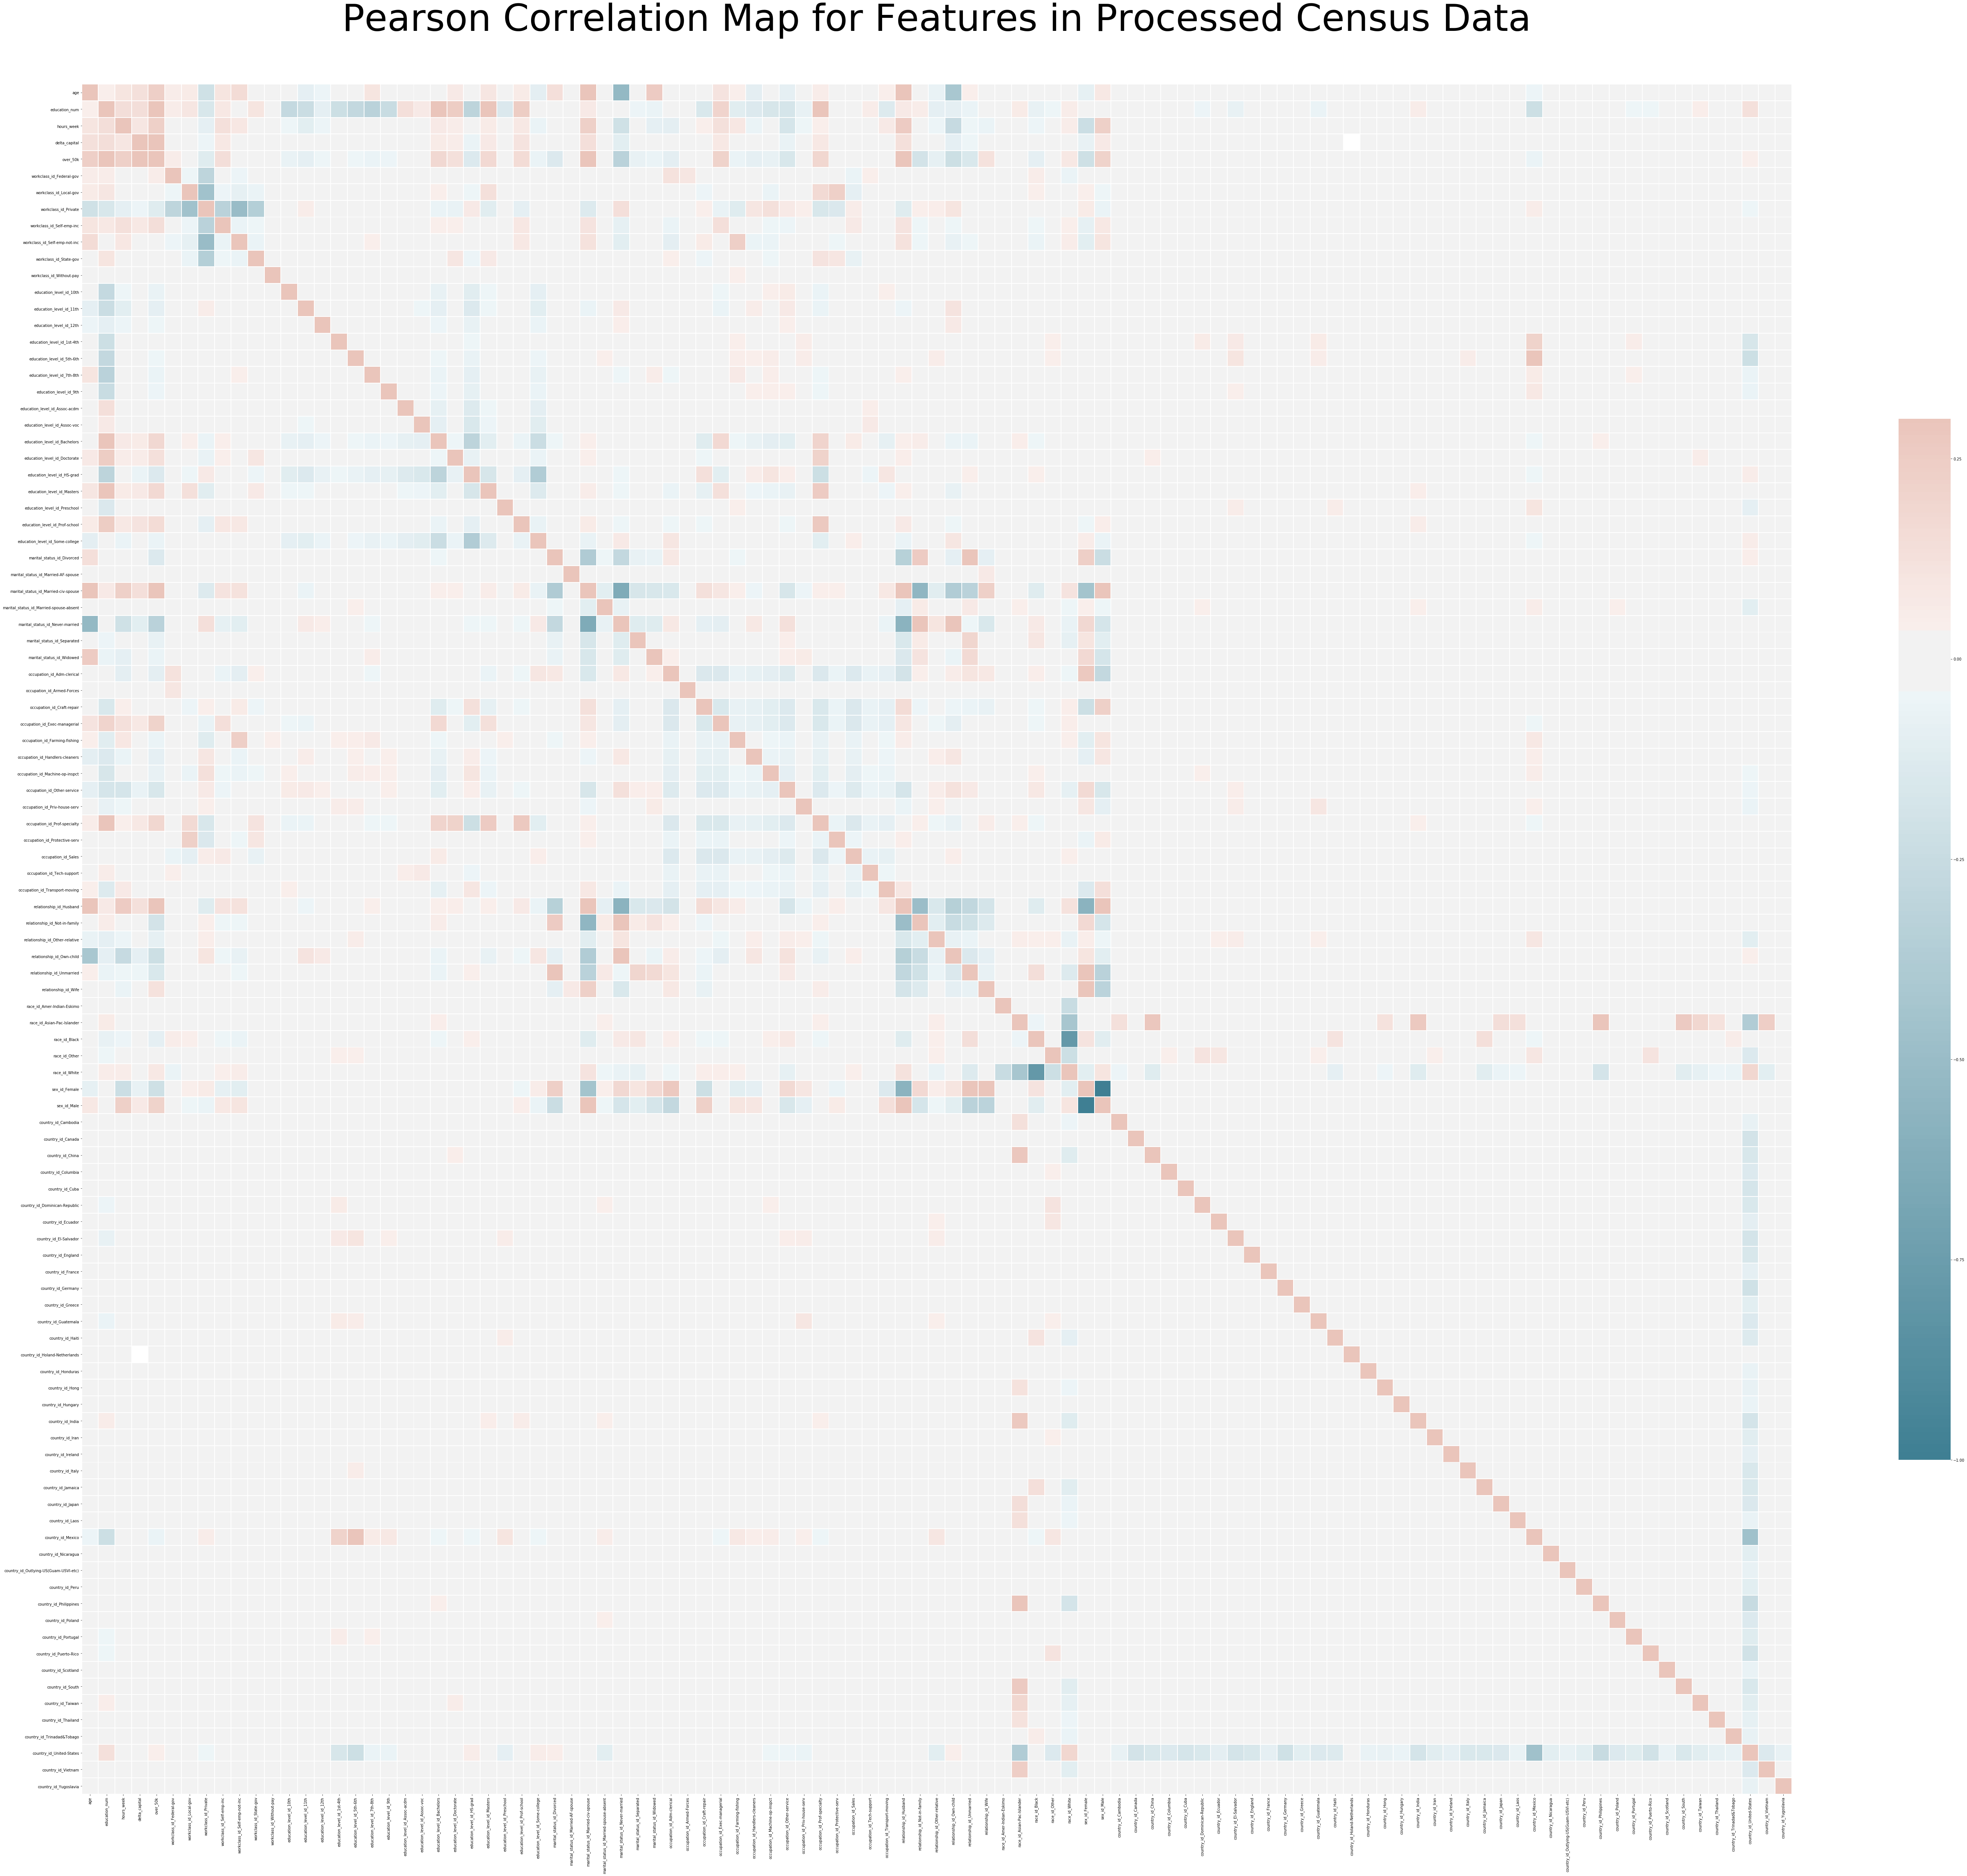


Feature correlations with over_50k:
age                                      0.237040
education_num                            0.332800
hours_week                               0.227199
delta_capital                            0.310605
over_50k                                 1.000000
workclass_id_Federal-gov                 0.059174
workclass_id_Local-gov                   0.029731
workclass_id_Private                    -0.116721
workclass_id_Self-emp-inc                0.137845
workclass_id_Self-emp-not-inc            0.021828
workclass_id_State-gov                   0.009514
workclass_id_Without-pay                -0.007618
education_level_id_10th                 -0.069813
education_level_id_11th                 -0.086078
education_level_id_12th                 -0.045636
education_level_id_1st-4th              -0.034456
education_level_id_5th-6th              -0.046120
education_level_id_7th-8th              -0.057080
education_level_id_9th                  -0.054675
education_lev

In [11]:
#plotting
c_matrix = records.corr() #compute correlation matrix
f, ax = pl.subplots(figsize=(103, 103)) #specify plot dimensions
cmap = sns.diverging_palette(220, 20, as_cmap=True) #custom color palette 
pl.title('Pearson Correlation Map for Features in Processed Census Data', y=1.03, size=100) #figure title
sns.heatmap(c_matrix, cmap=cmap, vmax=0.3, center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.5}) #plot the heatmap itself
pl.savefig('correlation_figure_all.jpg') #save heatmap figure as a jpg
pl.show()

print('\nFeature correlations with over_50k:')
print(c_matrix['over_50k'])

It is immediately clear that many of the variables are not strongly correlated with our target variable, over_50k (fifth column from the left/fifth row from the top). Some correlations here support conventional thought - e.g. being white, male, and completing some level of higher education are positively correlated with earning more than $50k.

Of particular interest to me was the correlations associated with marrital status. In retrospect, I suppose the prospect of supporting a family may be a driver of pursuing higher income, whereas perhaps many unmarried individuals do not necessarily feel as driven to do so.

Visual inspection of the features' correlations with the over_50k variable reveals that no correlation is particularly strong (save for the trivial case of over_50k with itself). I am interested in the variables with the strongest correlation to over_50k:

In [12]:
print(c_matrix['over_50k'].loc[(abs(c_matrix['over_50k'])>0.3) & (c_matrix['over_50k'] < 1)]) #correlation must be greater than +/-0.3 and exclude the trivial case

education_num                           0.332800
delta_capital                           0.310605
marital_status_id_Married-civ-spouse    0.446192
marital_status_id_Never-married        -0.319536
relationship_id_Husband                 0.403706
Name: over_50k, dtype: float64


These five features are best-correlated with the target variable.

Finally, I will plot only the over_50k correlation column for clarity:

In [13]:
#plotting
c_matrix = records.corr() #compute correlation matrix
f, ax = pl.subplots(figsize=(50, 500)) #specify plot dimensions
cmap = sns.diverging_palette(220, 20, as_cmap=True) #custom color palette 
pl.title('Pearson Correlation Map for Features in Processed Census Data', y=1.03, size=75) #figure title
sns.heatmap(c_matrix[['over_50k']], cmap=cmap, vmax=0.3, center=0, square=True, linewidths=1) #plot the heatmap itself
pl.savefig('correlation_figure_over_50k.jpg') #save heatmap figure as a jpg
pl.show()

Right now, my feature set has length 103, which is a bit long for my preference. I do not want to risk overfitting, so I would like to reduce the dimensionality.

With so many features with minimal correlation to my target variable, I think it would be best to drop some of them. I will use a correlation of +/- 0.1 as a threshold for this:

In [41]:
print('Number of features with correlation to target > 0.1: ' + str(c_matrix['over_50k'].index[(abs(c_matrix['over_50k'])>0.1) & (c_matrix['over_50k']!=1)].size))

print('\nTheir names are:\n')

top_feats = c_matrix['over_50k'].index[(abs(c_matrix['over_50k'])>0.1) & (c_matrix['over_50k']!=1)].tolist() #list of important indicex names
for i in top_feats:
    print(i)

Number of features with correlation to target > 0.1: 24

Their names are:

age
education_num
hours_week
delta_capital
workclass_id_Private
workclass_id_Self-emp-inc
education_level_id_Bachelors
education_level_id_Doctorate
education_level_id_HS-grad
education_level_id_Masters
education_level_id_Prof-school
marital_status_id_Divorced
marital_status_id_Married-civ-spouse
marital_status_id_Never-married
occupation_id_Exec-managerial
occupation_id_Other-service
occupation_id_Prof-specialty
relationship_id_Husband
relationship_id_Not-in-family
relationship_id_Own-child
relationship_id_Unmarried
relationship_id_Wife
sex_id_Female
sex_id_Male


We are left with 24 features whose correlation coefficient with over_50k is greater than 0.1. These will be the ones I will use moving forward.

As an aside, we can summarize these features with a few general words: age, education, hours worked, net capital, occupation, marital status, family relationship, and sex. I suspect that the relationship_id features may be partially redundant. I anticipate that they would be fairly well-explained by marital_status_id, sex_id, and age, but I am not sure. If I have time at the end, I will come back and take a look at this.

In [40]:
records = records.loc[:, top_feats]
records.to_csv('processed_data.csv', sep=',') #save final processed data

I will now move forward with developing the model.